<a href="https://colab.research.google.com/github/cr21/Unsupervised-Machine-Learning-Clustering/blob/main/K-meansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# MSIST
# NG
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import paired_manhattan_distances
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics.pairwise import  cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.datasets import fetch_openml
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import contingency_matrix
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
tf.keras.datasets.fashion_mnist?

In [3]:
def load_fashionData():
  # Load Fashion Mnist dataset
  fashion_mnist = tf.keras.datasets.fashion_mnist

  (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

  # our train data is images (28*28) we need to flatten it
  flatten_train_images = []
  for image in train_images:
    flatten_train_images.append(image.flatten())

  # convert in numpy array
  flatten_train_images = np.array(flatten_train_images)
  # normalize images
  flatten_train_images = flatten_train_images / 255


  # our test data is images (28*28) we need to flatten it
  flatten_test_images = []
  for image in test_images:
    flatten_test_images.append(image.flatten())

  # convert in numpy array
  flatten_test_images = np.array(flatten_test_images)
  # normalize images
  flatten_test_images = flatten_test_images / 255

  # combine test and train data
  fshn_mnist_data =  np.concatenate((flatten_train_images, flatten_test_images), axis = 0)
  fshn_mnist_labels = np.concatenate((train_labels, test_labels), axis = 0)

  return fshn_mnist_data, fshn_mnist_labels


In [4]:
def loadNGData(cats = [], seed = 20) :
  data = fetch_20newsgroups( remove=('headers','footers','quotes'), random_state= 20)
# Load News group data using sklearn library dataset.
  
  if len(cats) == 0:

    cats = ['talk.politics.guns',
         'talk.politics.mideast',
         ]
  
  dataset = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'), random_state= seed)
  data = dataset.data
  labels = dataset.target
  # vectorize the text data
  vectorizer = TfidfVectorizer(stop_words='english',min_df = 5)
  # vectorize train data
  ngVectorData = vectorizer.fit_transform(data)
  ngVectorDataDense = ngVectorData.toarray()

  return ngVectorDataDense, labels









In [5]:
ngData, ngLabels = loadNGData([], 15)


In [6]:
# subset
ngData2000 = ngData[:2000]
ngLabels2000 = ngLabels[:2000]


In [7]:
def loadMnistDigitData():
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True)  
  # Normalize the data
  X = X/255
  return X, y

In [8]:
X,y  = loadMnistDigitData()




In [9]:
# Function: getEuclidianDistance  
    # Get euclidean pairwise distance between dataset 

""" 
  Param : 
        X : Data point in data set 
        Y : centroid in dataset
        
  return :
        pairwise distance between X and Y
"""
# -------------
# Returns Get euclidean pairwise distance between dataset
def getEuclidianDistance(X, centroid):
  
  dist = euclidean_distances( X, centroid)
  
  return dist


# Function: getCosineDistance  
    # Get cosine pairwise distance between dataset 

""" 
  Param : 
        X : Data point in data set 
        centroid : centroid in dataset
        
  return :
        pairwise cosine distance between X and centroid
"""
# -------------
# Returns Get  pairwise cosine distance between dataset
def getCosineDistance(X, centroid):
  return cosine_similarity ( X, centroid )


In [10]:
# Function: GetMembership  This is M step in Kmeans Algorithm

""" 
  Param : 
        features :  feature value 
        labels :    true labels
        centroids : centroids
        metric :  metric value to use [ Euclidean, Cosine]
  return :
        new membership based on centroids and metric
"""
# https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
# -------------
# Returns a True Membership for each piece of data in the dataset based on centroids 
def getMembership(features, trueLabel, centroids, metric = 'euclidean'):

    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.
    pairedDist = None
    predLabel = None
    if metric == 'euclidean':
      pairedDist = getEuclidianDistance(features, centroids)
      
      predictIndex = np.argmin(pairedDist,axis=1)
      # print("predictIndex",predictIndex)
      # predLabel  = trueLabel[predictIndex]
    elif metric == 'cosine':
      #print('cosine Distance')
      pairedDist = getCosineDistance(features, centroids)
      predictIndex = np.argmax(pairedDist, axis=1)
      # predLabel  = trueLabel[predictIndex]
    # print(predictIndex)
    return predictIndex

    



# Function: Get Centroids
"""
  Param : 
    dataset     : dataset
    trueLabels  : trueLabels
    membership  : membership
    k           : number of centroid

  Return :
    new centroid

"""
# -------------
# Returns k random centroids, each of dimension n.
def getCentroids(dataSet, trueLabels, membership, centroids, k) :
#     # Each centroid is the geometric mean of the points that
#     # have that centroid's label. Important: If a centroid is empty (no points have
#     # that centroid's label) you should randomly re-initialize it.
    newCentroids = np.zeros_like(centroids)
    #print("centroids length ", len(centroids))
    for j in range(len(centroids)) :
      #  get all the element with memebership equals to j
      C_j = dataSet[ membership == j]

      # if we return valid clusters members take mean
      if len(C_j) != 0:
        newCentroids[j] = np.mean(C_j, axis=0 )
    return newCentroids


In [11]:
from tqdm import tqdm

In [12]:

# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids 

"""
  Param : 
        dataset : dataset to cluster on
        k       : Number of cluster to look into
  return :
        k cluster 
"""
MAX_ITERATIONS = 1000
def kmeans(features, labels, k, metric = 'euclidean'):
    
    # Initialize centroids randomly
    numFeatures = len(features)
    # centroids = features[np.random.choice(features.shape[0], k, replace=False)]
    centroids = features[np.random.choice(np.arange(len(features)), k, replace=False)]
    print(centroids.shape)
    iterations = 0
    oldCentroids = None
    
    # Run the main k-means algorithm
    while   (iterations <  MAX_ITERATIONS ) :
        # print(f"iteration : {iterations}")
        # update old centroids 
        oldCentroids = np.copy(centroids)
        # increase the iterations count
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        membership = getMembership(features,labels,  centroids, metric)
        
        # Assign centroids based on datapoint labels
        centroids = getCentroids(features, labels, membership,  centroids, k)

        # check for convergence
        if np.array_equal(centroids, oldCentroids) :
          return membership, centroids
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return membership,centroids



In [45]:
# https://towardsdatascience.com/clustering-for-data-nerds-ebbfb7ed4090
"""
  Param : 
        membership : data point membership of cluster
        labels       :  true labels
  return :
       avg gini index of clustering 
"""
def getGini(membership , labels) :
  CM = contingency_matrix(labels, membership)
  giniIndex = 0

  ginidensity = 0

  for _m in CM :
    total_dataPoint = np.sum(_m)
    # print("total_datapoint", total_dataPoint)
    ginidensity += total_dataPoint
    counter = 0
    for count in  _m :
      counter += pow(count/ total_dataPoint, 2)
    giniIndex += (1 - counter) * total_dataPoint
  gini_coeff = giniIndex/ ginidensity

  return gini_coeff
  

In [46]:
#https://stats.stackexchange.com/questions/95731/how-to-calculate-purity

#    |  T1 |  T2  |  T3
# ---------------------
# C1 |  0  |  53  |  10
# C2 |  0  |  1   |  60
# C3 |  0  |  16  |  0
 # impurity  =  53 +  60 + 16 ( 53+10+1+16)

"""
  Param : 
        membership : data point membership of cluster
        labels       :  true labels
  return :
        avg impurity of clusters . This is similar to entropy .
"""
def getImpurity(membership, labels):
  CM = contingency_matrix(labels, membership)
  truthCount = np.sum(np.amax(CM,axis=1))
  
  # truthCount = np.sum(np.amax(CM), axis = 0 )
  totalCount = np.sum(CM)

  purity = truthCount / totalCount 

  return purity

  

In [15]:
# Run on MNIST dataset
# mbr, cntrid = kmeans(X, y, 10)
def runClustering(dataset, labels, k, metric = 'euclidean'):
  membership, centroids = kmeans(dataset, labels, k, metric)
  impurity = getImpurity(membership, labels)
  gini = getGini(membership, labels)

  return impurity, gini

In [42]:
# Mnist Dataset K = 10 

impurity, gini = runClustering(X, y,10)
print(f" K value : {10} gini : {gini} ,  impurity : {impurity}")

# Mnist Dataset K = 5

impurity, gini = runClustering(X, y,5)
print(f" K value : {5} gini : {gini} ,  impurity : {impurity}")

# Mnist Dataset K = 15 

impurity, gini = runClustering(X, y,15)
print(f" K value : {15} gini : {gini} ,  impurity : {impurity}")


(10, 784)
 K value : 10 gini : 0.5549444980020286 ,  impurity : 0.5868285714285715
(5, 784)
 K value : 5 gini : 0.3296773664567851 ,  impurity : 0.7885571428571428
(15, 784)
 K value : 15 gini : 0.6314123468218275 ,  impurity : 0.48987142857142857


In [43]:
# Run Kmeans on Fashion MNIST data
fashionData, fashionLabel = load_fashionData()

# Mnist Dataset K = 10 

impurity, gini = runClustering(fashionData, fashionLabel,10)
print(f"Fashion DataSet K value : {10} gini : {gini} ,  impurity : {impurity}")

# Mnist Dataset K = 5

impurity, gini = runClustering(fashionData, fashionLabel,15)
print(f"Fashion DataSet K value : {5} gini : {gini} ,  impurity : {impurity}")

# Mnist Dataset K = 15 

impurity, gini = runClustering(fashionData, fashionLabel,15)
print(f"Fashion DataSet K value : {15} gini : {gini} ,  impurity : {impurity}")


(10, 784)
Fashion DataSet K value : 10 gini : 0.5669672204081633 ,  impurity : 0.5787428571428571
(15, 784)
Fashion DataSet K value : 5 gini : 0.627551575510204 ,  impurity : 0.4994142857142857
(15, 784)
Fashion DataSet K value : 15 gini : 0.6622499061224492 ,  impurity : 0.4567


In [44]:
# Run Kmeans on NG Data data
# fashionData, fashionLabel = load_fashionData()


# NG  Dataset K = 20 
impurity, gini = runClustering(ngData2000, ngLabels2000, 20, 'cosine')
print(f"News Group DataSet K value : {20} gini : {gini} ,  impurity : {impurity}")

# NG  Dataset K = 5
impurity, gini = runClustering(ngData2000, ngLabels2000, 5, 'cosine')
print(f"News Group K value : {5} gini : {gini} ,  impurity : {impurity}")

# NG  Dataset K = 15 

impurity, gini = runClustering(ngData2000, ngLabels2000, 15, 'cosine')
print(f"News Group K value : {15} gini : {gini} ,  impurity : {impurity}")



# impurity, gini = runClustering(fashionData, fashionLabel,15)
# print(f"Fashion DataSet K value : {5} gini : {gini} ,  impurity : {impurity}")

# # Mnist Dataset K = 15 

# impurity, gini = runClustering(fashionData, fashionLabel,15)
# print(f"Fashion DataSet K value : {15} gini : {gini} ,  impurity : {impurity}")


(20, 24164)
Fashion DataSet K value : 20 gini : 0.8404069449891879 ,  impurity : 0.3075
(5, 24164)
Fashion DataSet K value : 5 gini : 0.5222992597197814 ,  impurity : 0.634
(15, 24164)
Fashion DataSet K value : 15 gini : 0.7680554228590378 ,  impurity : 0.377


1) 
**E step is achieve minimization given Centroids **

<font color='red'> **proof by contradiction** </font>


suppose After E steps that gives the memebership doest not acheive minimum objective given the centroids.
suppose  there is better membership   for $\pi_ik$ and it is moved from cluster k to k', thus the value of distance between $\pi_ik$ to k will increase, because k'  is not the minimum.


this will not update the objective function since $\pi_ik'$ is greater than $\pi_ik$. This is contradiction.

2) $\mu_k$ represent the centroids for cluster k, given the current memebership, to find the new centroids based on current membership we used below formula

$\mu_k = \Sigma( \pi_ik) *  xi ) /
(\Sigma (\pi_ik))$

we can prove this by using 1st order optimization problem and find the minimum value for $\mu_k$ for objective function.

<!-- [link text](https://drive.google.com/file/d/15WZcJLD3Y0yfAg6l-OuTeVbXTd-gaF62/view?usp=sharing) -->

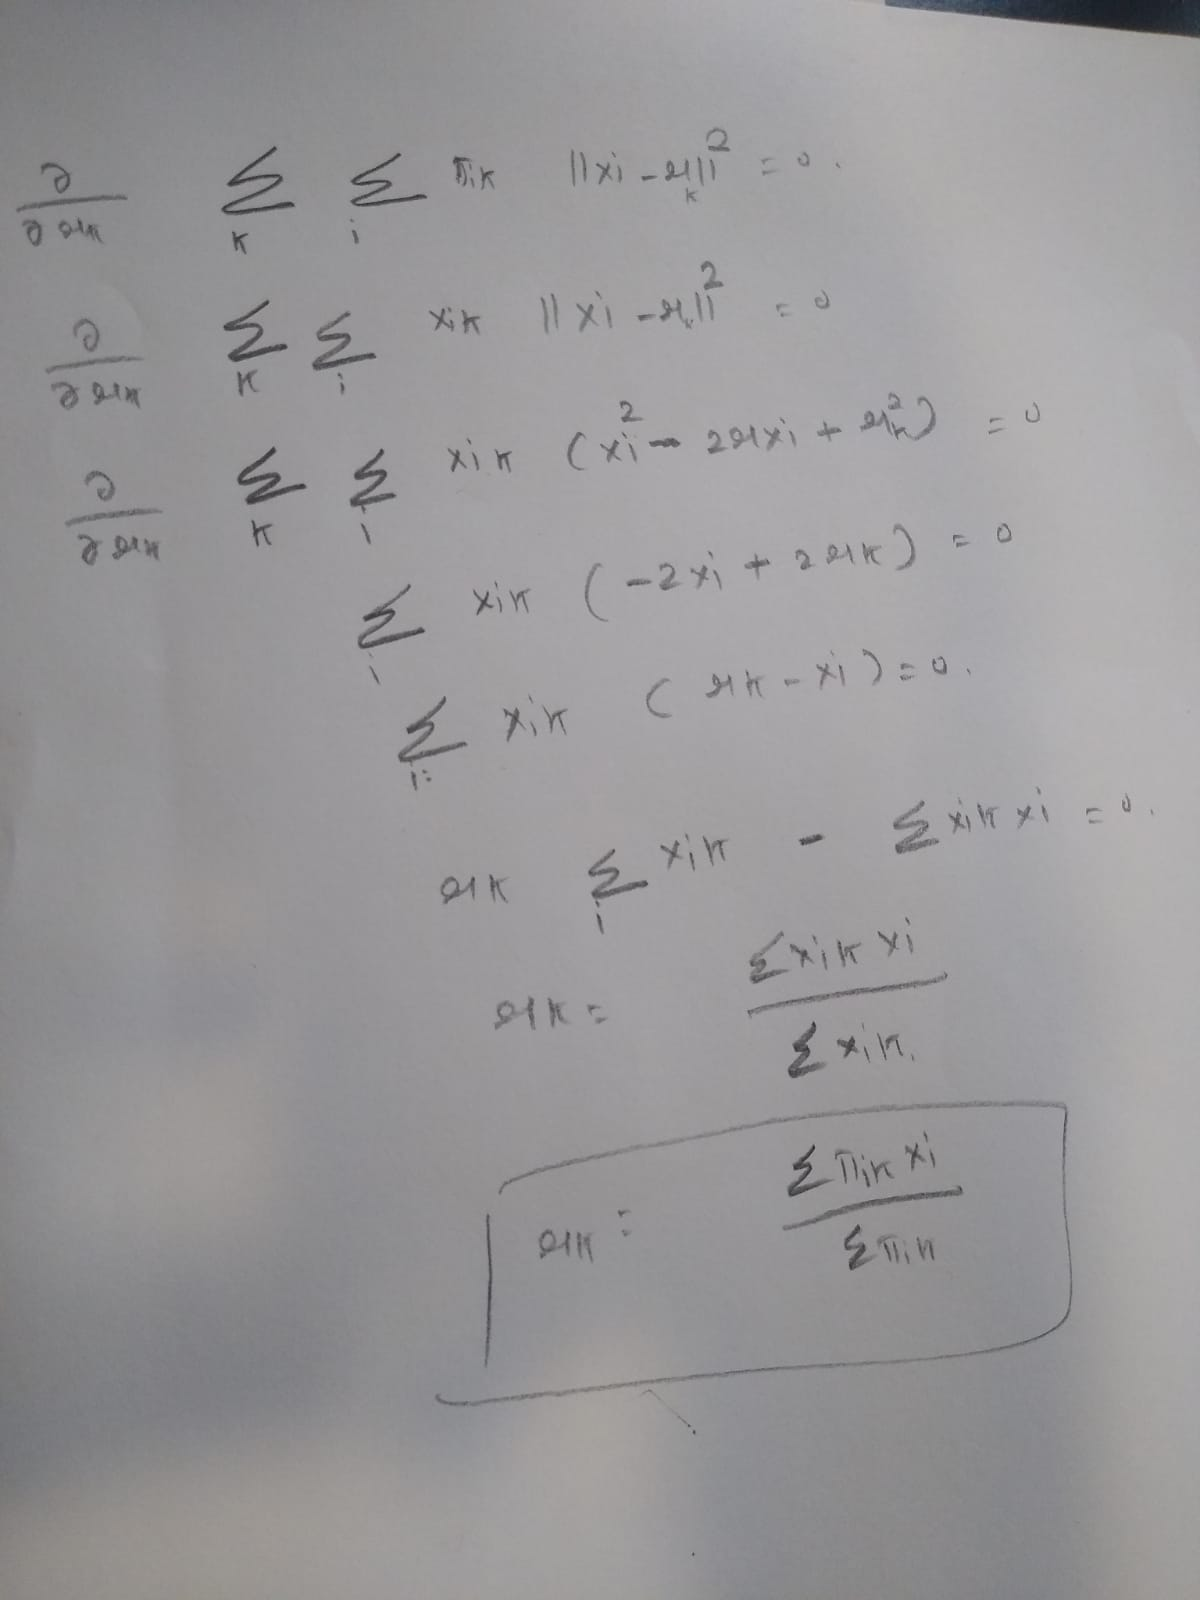

**) Explain why KMeans has to stop (converge), but not necessarily to the global minimum objective value.**

Kmeans Global minimization function is non convex function so it has one global minima and multiple local minima. 

We can achive global minimum objective value in two cases 


1) If we have exhausted all the possibe combinations of the function space we can achieve global minimum. This is practically not possible because of exponential number of combinations.

2) If we somehow intialize our centroid in the location in vicinity of true global minima we might get global minima.This practically possible if we try enough time with proper random initialization we could do much better.

3) Theoritically it is possible to get minimum but practically it is impossible.



In [48]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [49]:
cd drive/MyDrive/Dataset/


/content/drive/MyDrive/Dataset


In [50]:
ls

'Convolution Layer.ipynb'           mnist.log       'MSR-LA - 3467.docx'
'Copy of Convolution Layer.ipynb'   model2.log       PetImages/
 dogscats.npy                       model.log        proof_1b.jpeg
 dogscats.txt                       model.log1      'readme[1].txt'
 kagglecatsanddogs_3367a.zip        model.log11      training_data.npy
 MNIST/                             model.log.gdoc
